# Chapter 5 Resampling Methods
Covers resampling data through bootstraping and cross validation. Cross validation gets us an error estimate for our test data and boostraping provides estimates for parameter accuracy.

### Cross Validation
Usually a test set is not available so a simple strategy to create one is to split the available data into training and testing (validation set). For quantitative responses usually use MSE, for categorical can use error rate, area under the curve, F1 score, weighting of confusion matrix, etc...

### Leave One Out Cross Validation
LOOCV has only one observation in the test set and uses all other n-1 observations to build a model. n different models are built leaving out each observation once and error is averaged over these n trials.  LOOCV is better than simple method above. Model is built on nearly all the data and there is no randomness in the splits since each observation will be left out once. It is computationally expensive especially with large n and a complex model.

### k-fold cross validation
Similar to LOOCV but this time you leave some number greater than 1 out. Here, k is the number of partitions of your sample, so if you have 1000 observations and k = 10, the each fold will be 100. These 100 observations would act as your test set. Get an MSE for each fold of these 100 observations and take the average. LOOCV is a special case of k-fold CV whenever k equals the number of observations.

### bias-variance tradeoff between LOOCV and k-folds
Since LOOCV trains on nearly all the data, the test error rate will generally be lower than k-fold and there for less biased. LOOCV will have higher variance since all n models will be very highly correlated to one another. Since the models won't differ much, the test error rate (which what CV is measuring) will vary more than k-fold which has fewer models that are less correlated with one another. A value of k between 5 and 10 is a good rule of thumb that balances the trade-off between bias and variance

# 1
Minimize $$Var(\alpha X + (1 - \alpha)Y)$$

Properties of variance and covariance
$$=Var(\alpha X) + Var((1 - \alpha)Y) + 2Cov(\alpha X, (1 - \alpha)Y)$$
$$=\alpha^2Var(X) + (1 - \alpha)^2Var(Y) + 2(\alpha)(1 - \alpha)(Cov(X, Y)$$

Take derivative and set to 0
$$2\alpha Var(X) - 2(1 - \alpha)Var(Y) + (2 - 4\alpha)Cov(X, Y) = 0$$
Collect terms
$$2\alpha Var(X) + 2 \alpha Var(Y) - 4\alpha Cov(X, Y) = 2Var(Y) - 2Cov(X, Y)$$
Solve for $\alpha$
$$\alpha = \frac{Var(Y) - Cov(X, Y)}{Var(X) + Var(Y) - 2Cov(X, Y)}$$

# 2
a) $\frac{n-1}{n}$  
b) $\frac{n-1}{n}$  
c) Since bootstrapping is sampling with replace, the probability of being any jth obsevation is $\frac{1}{n}$. The probability of not being the jth observation is $1 - \frac{1}{n}$. Since each draw is independent we can just multiply the probabilities together to get the probability that the jth observation is not in the sample at all

d)-f) Porbability that jth observation is in the bootstrap sample is $$Pr(in) = 1 - Pr(out)$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
#2 c-f
list_n = [5, 100, 10000, 100000]
for n in list_n:
    print("n={}, probability that jth observation is in the bootstrap sample ={:.2%}".format(n, (1-(1-1/n)**n)))

n=5, probability that jth observation is in the bootstrap sample =67.23%
n=100, probability that jth observation is in the bootstrap sample =63.40%
n=10000, probability that jth observation is in the bootstrap sample =63.21%
n=100000, probability that jth observation is in the bootstrap sample =63.21%


0.6321223982317534


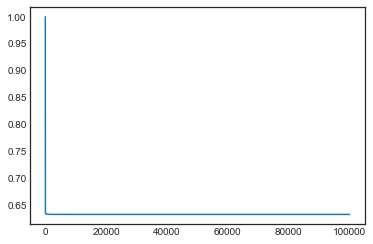

In [3]:
# 2g
x = np.arange(1, 100001)
y = 1-(1 - 1/x) ** x
# plt.plot(x[:10],y[:10])
plt.plot(x,y)
print(min(y))

As we can see, the first point has probability equal to one, which makes sense because if we only have on observation it must be in the bootstrap sample. After, the probability starts decreasing until it reaches a plateau close to the value 0.63.
$$ \lim_{n \rightarrow \infty} \left( 1- \left(1-\frac{1}{n}\right)^n \right) = 1- e^{-1} \approx 0.63212$$
 


In [4]:
# 2h
import random
n = 100
N = 10000
count = 0

for _ in range(N):
    # True equals 1 in Python
    # choices(l, k=k) takes k samples from the list l with replacement
    count += 4 in random.choices(range(1,n+1), k=n) 

print(count/N)

0.6301


In [5]:
data = np.random.randint(1, 101, (100, 10000))
np.any(data == 4, axis=0).mean()

0.6367

# 3 k-folder
a) K-fold CV works by taking the dataset given and randomly splitting it into k non-overlapping datasets. You can shuffle the data first and then just split at regular intervals. Train K models. For each model, use the kth region as the validation set and build on the other k-1 sets. Take the mean of the k errors found to estimate the true test error.  

b i) Advantage to validation set is that there are more test sets to validate on which should **reduce the bias** of what the overall error actually is. Variance should also decrease as the validation set approach is just one split of the data and that split could not represent the test data well. Disadvantage is training more models.  

b ii) Advantage to LOOCV is a **decrease in variance** as the k models are not as highly correlated as the each LOOCV model is. Also, K-folds is computationally less expensive. 

# 5 Default dataset

In [6]:
default = pd.read_excel('Data/Default.xlsx')
default['student_yes'] = (default['student'] == 'Yes').astype('int')
default['default_yes'] = (default['default'] == 'Yes').astype('int')
default.head()

,default,student,balance,income,student_yes,default_yes
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,1,0
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0


We are looking for LogisticRegression without regularization. In sklearn this is not implemented, but we can use l2 regularization and set C, the inverese strenght, to a very high number, effectively removing the regularization.

In [7]:
X = default[['income', 'balance']]
y = default['default_yes']

model = LogisticRegression(C=10**6, tol=1e-6)
model.fit(X,y)
print('Intercept: ', model.intercept_)
print('Coefficients: ', model.coef_)

Intercept:  [-11.5273343]
Coefficients:  [[2.07267113e-05 5.64079143e-03]]


In [8]:
# using statsmodel
f = 'default_yes ~ income+ balance'
res = smf.logit(formula = f, data= default).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Jan 2019   Pseudo R-squ.:                  0.4594
Time:                        23:55:03   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7)
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
test_error = 1-(y_test==y_pred).mean()
print(test_error)

0.032200000000000006


In [10]:
model = LogisticRegression(C=100000, tol=.0000001)

for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_error = 1-(y_test==y_pred).mean()
    print(test_error)

0.0252
0.026800000000000046
0.02200000000000002


The test error changes when different train test split have been made

In [11]:
X = default[['income', 'balance','student_yes']]
y = default['default_yes']
model = LogisticRegression(C=10**6, tol=1e-6)
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_error = 1-(y_test==y_pred).mean()
    print(test_error)

0.028000000000000025
0.029200000000000004
0.024800000000000044


So compared to the values above without the student dummy variable, it seems that adding the student variable does not help in any of the metrics since they are worse or very similar (although we should consider the variance, in a more careful analysis).

# 6 Bootstrap

In [12]:
#using generalized linear models with statsmodel
#see the wikipedia reference to understand why family is binomial
mod1 = smf.glm(formula='default ~ income + balance', data=default, family=sm.families.Binomial()).fit() #create & fit model
print(mod1.summary()) #show results

                        Generalized Linear Model Regression Results                        
Dep. Variable:     ['default[No]', 'default[Yes]']   No. Observations:                10000
Model:                                         GLM   Df Residuals:                     9997
Model Family:                             Binomial   Df Model:                            2
Link Function:                               logit   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -789.48
Date:                             Mon, 07 Jan 2019   Deviance:                       1579.0
Time:                                     23:55:03   Pearson chi2:                 6.95e+03
No. Iterations:                                  9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

In [13]:
def boot_fn(default):
    mod = smf.glm(formula='default_yes ~ income + balance', data=default, family=sm.families.Binomial()).fit() 
    coef_income = mod1.params[1]
    coef_balance = mod1.params[2]
    return [coef_income, coef_balance]

def boot(X, bootSample_size=None):

    #assign default size if non-specified
    if bootSample_size == None:
        bootSample_size = len(X)

    #create random integers to use as indices for bootstrap sample based on original data
    bootSample_i = (np.random.rand(bootSample_size)*len(X)).astype(int)
    bootSample_i = np.array(bootSample_i)
    bootSample_X = X.iloc[bootSample_i]
    return bootSample_X
    

In [14]:
#running model for bootstrapped samples
coefficients = [] #variable initialization
n = 100 #number of bootstrapped samples

for i in range(n):
    coef_i = boot_fn(boot(default)) #determining coefficients for specific bootstrapped sample
    coefficients.append(coef_i) #saving coefficients value

print(pd.DataFrame(coefficients).mean()) #print average of coefficients

0   -0.000021
1   -0.005647
dtype: float64


# 7 Leave one out

In [15]:
weekly = pd.read_csv('Data/weekly.csv')
weekly['Direction_Up'] = (weekly['Direction']=='Up').astype(int)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_Up
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


In [16]:
# a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2.
X = weekly[['Lag1', 'Lag2']]
y = weekly.Direction_Up
mod = LogisticRegression(C=10**6, tol=10**-7)
mod.fit(X, y)
print(mod.intercept_, mod.coef_, (mod.predict(X) == y).mean())  # accuracy

[0.22122405] [[-0.03872222  0.0602483 ]] 0.5555555555555556


In [17]:
# b) Fit a logistic regression model that predicts Direction using Lag1 and 
# Lag2 using all but the first observation.
mod = LogisticRegression(C=10**6, tol=10**-7)
mod.fit(X.iloc[1:], y.iloc[1:])
print(mod.intercept_, mod.coef_, (mod.predict(X) == y).mean())

[0.22324305] [[-0.03843317  0.06084763]] 0.5564738292011019


In [18]:
print("Prediction = {}, ground truth={}".format(mod.predict(X.iloc[[0]]),y[0]))

Prediction = [1], ground truth=0


The result is misclasiffied

In [19]:
n = len(X)
errors = np.zeros(n)
for i in range(n):
    one_out = ~X.index.isin([i])
    mod.fit(X[one_out], y[one_out])
    if mod.predict(X.iloc[[i]])!=y[i]:
        errors[i]=1
print(errors.mean())

0.44995408631772266


# 8 Cross validation

In [20]:
np.random.seed(1)
y = np.random.normal(size = 100)
x = np.random.normal(size = 100)
epsilon = np.random.normal(size=100)
y= x-2*x**2 + epsilon


In this dataset, n=100 and p = number of predictors = 2 ( x and $x^2$)

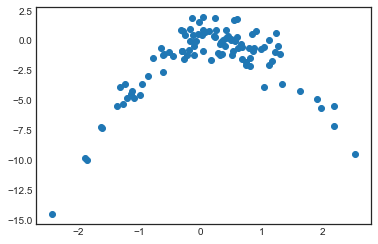

In [21]:
plt.scatter(x,y)

- Quadratic plot
- Convex function with negative concavity
- X from about -2 to 2
- Y from about -10 to 2

from sklearn.pipeline import Pipeline: 
Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. 

In [22]:
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

loo = LeaveOneOut()
# Organize data in dataframe
df = pd.DataFrame({'x':x, 'y':y})
min_deg = 1
max_deg = 4+1
scores = []
for i in range(min_deg,max_deg):
    for train_idx, test_idx in loo.split(df):
        X_train, X_test = df['x'][train_idx], df['x'][test_idx]
        y_train, y_test = df['y'][train_idx], df['y'][test_idx]
        model = Pipeline([('poly', PolynomialFeatures(degree = i)),
                      ('linear', LinearRegression())])
        model.fit(X_train[:,np.newaxis], y_train)

        # MSE
        score = mean_squared_error(y_test, model.predict(X_test[:,np.newaxis]))
        scores.append(score)
    print('Model %i (MSE): %f' % (i,np.mean(scores)))
    scores = []

Model 1 (MSE): 8.292212
Model 2 (MSE): 1.017096
Model 3 (MSE): 1.046553
Model 4 (MSE): 1.057493


In [23]:
min_deg = 1  
max_deg = 4+1 

for i in range(min_deg, max_deg):
    pol = PolynomialFeatures(degree = i)
    X_pol = pol.fit_transform(df['x'][:,np.newaxis])
    y = df['y']

    model = sm.OLS(y, X_pol)
    results = model.fit()

    print(results.summary())  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     9.460
Date:                Mon, 07 Jan 2019   Prob (F-statistic):            0.00272
Time:                        23:55:10   Log-Likelihood:                -242.69
No. Observations:                 100   AIC:                             489.4
Df Residuals:                      98   BIC:                             494.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7609      0.280     -6.278      0.0

# 9

In [24]:
boston = pd.read_csv('Data/boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [25]:
medv = boston.medv
mu = medv.mean()
print(medv.mean())

22.532806324110698


In [26]:
# Standard error = standard deviation / sqrt(number of observation)
SE = medv.std() / np.sqrt(len(medv))
print("Standard eror = ", SE)

Standard eror =  0.4088611474975351


In [27]:
# Estimate the SE of mu using bootstrap
means = [medv.sample(n = len(medv), replace=True).mean() for _ in range(1000)]
np.std(means)

0.4190510584687809

In [28]:
# 95% CI
SE = np.std(means)
print(mu - 2*SE, mu + 2*SE)

21.694704207173135 23.37090844104826


In [29]:
# median
medv.median()

21.2

In [30]:
# SE of median
medians = [medv.sample(n = len(medv), replace=True).median() for _ in range(1000)]
np.std(medians)

0.39181342498694416

In [31]:
# Quantile
medv.quantile(0.1)

12.75

In [32]:
# SE of mu_0.1
quantiles = [medv.sample(n = len(medv), replace=True).quantile(0.1) for _ in range(1000)]
np.std(quantiles)

0.48166647952706865